# Levenshtein distance and spelling corrections

The task introduces the Levenshtein distance - a measure that is useful in tasks such as approximate string matching.


Imports

In [108]:
from datasets import load_dataset
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish
from collections import Counter, defaultdict
import random
import string
import morfeusz2
import matplotlib.pyplot as plt
import ast
from Levenshtein import distance
import pandas as pd
from elasticsearch import Elasticsearch
from tqdm import tqdm
import numpy as np

tqdm.pandas()

## Tasks

Task objectives (8 points):
1. Use the corpus from exercise no. 1.

In [109]:
dataset = load_dataset("clarin-knext/fiqa-pl", "queries")

In [110]:
dataset

DatasetDict({
    queries: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 6648
    })
})

In [111]:
df=pd.DataFrame(dataset['queries'])

In [112]:
df

,_id,title,text
0,0,,Co jest uważane za wydatek służbowy w podróży ...
1,4,,Wydatki służbowe - ubezpieczenie samochodu pod...
2,5,,Rozpoczęcie nowego biznesu online
3,6,,„Dzień roboczy” i „termin płatności” rachunków
4,7,,Nowy właściciel firmy – Jak działają podatki d...
...,...,...,...
6643,4102,,"Jak mogę ustalić, czy moja stopa zwrotu jest „..."
6644,3566,,"Gdzie mogę kupić akcje, jeśli chcę zainwestowa..."
6645,94,,Wykorzystywanie punktów kart kredytowych do op...
6646,2551,,Jak znaleźć tańszą alternatywę dla tradycyjnej...


In [113]:
df = df.sample(100, random_state=42).reset_index(drop=True)

The dataset was limited to a random sample of 100 rows (random_state=42) to speed up processing and testing while maintaining consistency of results.

2. Use SpaCy [tokenizer API](https://spacy.io/api/tokenizer) to tokenize the text in the documents.

In [114]:
nlp = spacy.load("pl_core_news_sm")
tokenizer=nlp.tokenizer

In [115]:
df['tokens'] = df['text'].progress_apply(lambda doc: [token.text for token in nlp(doc)])

100%|██████████| 100/100 [00:01<00:00, 53.27it/s]


In [116]:
df['tokens']

0     [Gdzie, można, znaleźć, ceny, intraday, dla, f...
1     [Odliczenie, dla, biura, domowego, metodą, upr...
2     [Czy, reguła, wzrostu, dotyczy, wszystkich, ak...
3     [Co, zrobić, ze, swoimi, oszczędnościami, w, J...
4                [Jak, działa, handel, przedrynkowy, ?]
                            ...                        
95    [Dlaczego, nie, można, realizować, transakcji,...
96    [Jak, dodać, swój, dochód, do, mojego, salda, ...
97    [Czy, zawsze, będę, mógł, otrzymać, kartę, kre...
98                       [Definicja, handlu, dziennego]
99    [Jak, zwolnienie, podatkowe, za, działanie, =,...
Name: tokens, Length: 100, dtype: object

3. Compute **frequency list** for each of the processed files.

In [117]:
df['frequency_list'] = df['tokens'].progress_apply(lambda tokens: Counter(tokens))

100%|██████████| 100/100 [00:00<00:00, 33388.82it/s]


In [118]:
df['frequency_list']

0     {'Gdzie': 1, 'można': 1, 'znaleźć': 1, 'ceny':...
1     {'Odliczenie': 1, 'dla': 1, 'biura': 2, 'domow...
2     {'Czy': 1, 'reguła': 1, 'wzrostu': 1, 'dotyczy...
3     {'Co': 1, 'zrobić': 1, 'ze': 1, 'swoimi': 1, '...
4     {'Jak': 1, 'działa': 1, 'handel': 1, 'przedryn...
                            ...                        
95    {'Dlaczego': 1, 'nie': 1, 'można': 1, 'realizo...
96    {'Jak': 1, 'dodać': 1, 'swój': 1, 'dochód': 1,...
97    {'Czy': 1, 'zawsze': 1, 'będę': 1, 'mógł': 1, ...
98        {'Definicja': 1, 'handlu': 1, 'dziennego': 1}
99    {'Jak': 1, 'zwolnienie': 1, 'podatkowe': 1, 'z...
Name: frequency_list, Length: 100, dtype: object

4. Aggregate the result to obtain one global frequency list. This frequency list gives you unigram statistics of the words
   appearing in the corpus.

In [119]:
frequency_list = defaultdict(lambda: 0)

texts = df['text'].progress_apply(lambda s: s.lower())
for doc in tokenizer.pipe(texts, batch_size=50):
    for token in doc:
        frequency_list[token.text] += 1

100%|██████████| 100/100 [00:00<00:00, 50021.51it/s]


In [120]:
frequency_list

defaultdict(<function __main__.<lambda>()>,
            {'gdzie': 1,
             'można': 3,
             'znaleźć': 1,
             'ceny': 1,
             'intraday': 1,
             'dla': 7,
             'funduszy': 1,
             'inwestycyjnych': 2,
             '?': 86,
             'odliczenie': 1,
             'biura': 2,
             'domowego': 1,
             'metodą': 1,
             'uproszczoną': 1,
             'i': 15,
             'koszt': 1,
             'niestałej': 1,
             'modyfikacji': 1,
             'czy': 37,
             'reguła': 1,
             'wzrostu': 1,
             'dotyczy': 1,
             'wszystkich': 1,
             'akcji': 6,
             '/': 10,
             'etf': 1,
             'innych': 1,
             'papierów': 1,
             'wartościowych': 1,
             ',': 36,
             'tylko': 1,
             'określonych': 1,
             'co': 5,
             'zrobić': 3,
             'ze': 3,
             'swoimi': 1,
        

In [121]:
sorted_frequency_list = dict(sorted(frequency_list.items(), key=lambda item: item[1], reverse=True))

In [122]:
sorted_frequency_list

{'?': 86,
 'czy': 37,
 ',': 36,
 'w': 25,
 'na': 23,
 'jak': 22,
 'i': 15,
 'z': 15,
 'jest': 12,
 '/': 10,
 'są': 10,
 ')': 10,
 'powinienem': 9,
 'nie': 8,
 'do': 8,
 'za': 8,
 '(': 8,
 '.': 8,
 'dla': 7,
 'o': 7,
 'mogę': 7,
 'akcji': 6,
 'lub': 6,
 'się': 6,
 'jaki': 6,
 'co': 5,
 'jakie': 5,
 'jeśli': 5,
 'firmy': 5,
 'moje': 5,
 'akcje': 5,
 'kredyt': 5,
 'domu': 5,
 'kredytu': 4,
 'kredytową': 4,
 'może': 4,
 'od': 4,
 'dlaczego': 4,
 'mam': 4,
 'hipoteczny': 4,
 'poza': 4,
 'można': 3,
 'zrobić': 3,
 'ze': 3,
 'przypadku': 3,
 'inwestować': 3,
 'naszego': 3,
 'nadal': 3,
 'usa': 3,
 ':': 3,
 'będę': 3,
 'przy': 3,
 'po': 3,
 'rynek': 3,
 '„': 3,
 '”': 3,
 'aby': 3,
 '-': 3,
 'nieruchomość': 3,
 'właściciela': 3,
 'muszę': 3,
 'wpływ': 3,
 'to': 3,
 'konta': 3,
 'pracy': 3,
 'a': 3,
 'otrzymać': 3,
 'pieniądze': 3,
 'kredytowej': 3,
 'inwestycyjnych': 2,
 'biura': 2,
 'zakupu': 2,
 'usd': 2,
 'opcje': 2,
 'kredytem': 2,
 '\u200b\u200bale': 2,
 'inwestowanie': 2,
 'ira': 2,
 'rot

5. Apply a distortion function to the queries part of the corpus. In each query draw randomly one word and change one letter in the word to some other letter.

In [123]:
def distort_word(word):
    if len(word) < 2:  
        return word
    pos = random.randint(0, len(word) - 1)  
    char = random.choice(string.ascii_lowercase)  
    return word[:pos] + char + word[pos+1:]

In [124]:
df['distorted_queries'] = df['tokens'].progress_apply(lambda tokens: [distort_word(token) for token in tokens])

100%|██████████| 100/100 [00:00<00:00, 11126.36it/s]


In [125]:
df['distorted_queries']

0     [jdzie, możsa, pnaleźć, ceky, iytraday, dll, f...
1     [Odliczvnie, dlr, siura, dokowego, metoką, upr...
2     [Czx, regoła, hzrostu, dotymzy, wszysjkich, ak...
3     [Cs, zrobie, ce, ewoimi, oszczpdnościami, w, J...
4                [rak, eziała, handef, przedrynkswy, ?]
                            ...                        
95    [Dlactego, nme, monna, realizpwać, transaxcji,...
96    [Jqk, eodać, seój, dochhd, dt, mojegi, salfa, ...
97    [czy, zawszv, gędę, mlgł, otnzymać, kcrtę, kre...
98                       [Debinicja, tandlu, dzienneqo]
99    [Jaj, zwolmienie, pwdatkowe, sa, dhiałanie, =,...
Name: distorted_queries, Length: 100, dtype: object

6. Compute nDCG@10 for the distorted queris, using the same approach as in lab 2. This result will be the baseline
   for the other methods.

In [126]:
K = 10

def dcg_at_k(scores, k=K):
    scores = np.asarray(scores, dtype=float)[:k]
    if scores.size:
        return np.sum(scores / np.log2(np.arange(2, scores.size + 2)))
    return 0.0

def ndcg_at_k(scores, k=K):
    actual_dcg = dcg_at_k(scores, k)
    ideal_dcg = dcg_at_k(sorted(scores, reverse=True), k)
    return actual_dcg / ideal_dcg if ideal_dcg > 0 else 0.0

def compute_ndcg_baseline(df, distorted_queries_col, original_tokens_col, k=K):
    df['ndcg_baseline'] = df.apply(
        lambda row: ndcg_at_k(
            [1 if distorted == original else 0 for distorted, original in zip(row[distorted_queries_col], row[original_tokens_col])],
            k=k
        ),
        axis=1
    )
    return df

In [127]:
df['original_tokens'] = df['tokens']
df = compute_ndcg_baseline(df, 'distorted_queries', 'original_tokens', k=10)

In [128]:
mean_ndcg = df['ndcg_baseline'].mean()
print("Mean nDCG@10 for distorted queries is:", mean_ndcg)

Mean nDCG@10 for distorted queries is: 0.3335980380244666


The average nDCG@10 score for the malformed queries was 0.3335, which suggests a moderately low level of agreement between the malformed and original queries. 

7. Install [Morfeusz](http://morfeusz.sgjp.pl/download/) (Binding dla Pythona) and use it to find all words from the queries that do not appear in that dictionary. Only these words should be corected in the next step.

In [129]:
morfeusz = morfeusz2.Morfeusz()

In [130]:
df['invalid_words'] = df['distorted_queries'].progress_apply(
    lambda words: [word for word in words if any(tag == 'ign' for _, _, (_, _, tag, _, _) in morfeusz.analyse(word))]
)

100%|██████████| 100/100 [00:00<00:00, 438.50it/s]


In [131]:
df['invalid_words']

0     [jdzie, możsa, pnaleźć, ceky, iytraday, dll, f...
1     [Odliczvnie, dlr, metoką, uprosuczoną, ioszt, ...
2     [Czx, regoła, hzrostu, dotymzy, wszysjkich, ak...
3                [Cs, ewoimi, oszczpdnościami, Japonzi]
4                        [eziała, handef, przedrynkswy]
                            ...                        
95    [Dlactego, nme, monna, realizpwać, transaxcji,...
96    [Jqk, eodać, seój, dochhd, dt, mojegi, salfa, ...
97    [zawszv, gędę, mlgł, otnzymać, kcrtę, kredyiow...
98                       [Debinicja, tandlu, dzienneqo]
99    [zwolmienie, pwdatkowe, dhiałanie, khra, zm, y...
Name: invalid_words, Length: 100, dtype: object

8. Use Levenshtein distance and the frequency list, to determine the most probable correction of the words
    in the queries that were identified as invalid. (**Note**: You don't have to apply the distance directly. Any method that is more efficient than scanning the dictionary will be appreciated.)

In [132]:
words_to_correct = df['invalid_words'].tolist()

def find_best_correction(target_word, candidate_words):
    min_distance = float('inf')
    best_correction = None

    for word in candidate_words:
        if word != target_word:
            dist = distance(target_word, word)
            if dist < min_distance:
                min_distance = dist
                best_correction = word

    return best_correction

In [133]:
df['corrected_levenshtein'] = df.progress_apply(
    lambda row: [
        find_best_correction(word, sorted_frequency_list) if word in row['invalid_words'] else word 
        for word in row['distorted_queries']
    ],
    axis=1
)

100%|██████████| 100/100 [00:00<00:00, 114.72it/s]


In [134]:
print(df[['distorted_queries', 'corrected_levenshtein']].head())

                                   distorted_queries  \
0  [jdzie, możsa, pnaleźć, ceky, iytraday, dll, f...   
1  [Odliczvnie, dlr, siura, dokowego, metoką, upr...   
2  [Czx, regoła, hzrostu, dotymzy, wszysjkich, ak...   
3  [Cs, zrobie, ce, ewoimi, oszczpdnościami, w, J...   
4             [rak, eziała, handef, przedrynkswy, ?]   

                               corrected_levenshtein  
0  [gdzie, można, znaleźć, ceny, intraday, dla, f...  
1  [odliczenie, dla, siura, dokowego, metodą, upr...  
2  [czy, reguła, wzrostu, dotyczy, wszystkich, ak...  
3  [?, zrobie, ce, swoimi, oszczędnościami, w, ja...  
4             [rak, działa, handel, przedrynkowy, ?]  


9. Compute nDCG@10 for your implementation of the spelling correction method.

In [135]:
def dcg_at_k(scores, k=10):
    scores = np.asarray(scores)[:k]
    if scores.size:
        return np.sum(scores / np.log2(np.arange(2, scores.size + 2)))
    return 0.0

def ndcg_at_k(scores, k=10):
    actual_dcg = dcg_at_k(scores, k)
    ideal_dcg = dcg_at_k(sorted(scores, reverse=True), k)
    return actual_dcg / ideal_dcg if ideal_dcg > 0 else 0.0

In [136]:
df['ndcg_corrected'] = df.apply(
    lambda row: ndcg_at_k(
        [1 if corrected == original else 0 for corrected, original in zip(row['corrected_levenshtein'], row['original_tokens'])],
        k=10
    ),
    axis=1
)

In [137]:
mean_ndcg = df['ndcg_corrected'].mean()
print("Mean nDCG@10 for spelling correction is:", mean_ndcg)

Mean nDCG@10 for spelling correction is: 0.6995255182009739


The average nDCG@10 score for queries after spelling correction was 0.6995, which is a significant improvement compared to the baseline value (0.3335). This result suggests that the applied spelling correction method effectively improves the consistency of queries with the originals.

10. Use ElasticSearch's fuzzy match and compute nDCG@10 for this approach.

In [138]:
es = Elasticsearch(['http://localhost:9200/'])

In [139]:
es.info()

ObjectApiResponse({'name': 'node-1', 'cluster_name': 'my-application-cluster', 'cluster_uuid': 'hy4VLD6oQSWoC97Nt5ghbg', 'version': {'number': '8.15.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '98adf7bf6bb69b66ab95b761c9e5aadb0bb059a3', 'build_date': '2024-09-19T10:06:03.564235954Z', 'build_snapshot': False, 'lucene_version': '9.11.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [140]:
if es.ping():
    print("Połączono z Elasticsearch")
else:
    print("Brak połączenia z Elasticsearch")

Połączono z Elasticsearch


In [141]:
index_name = "queries_index"

index_settings = {
    "settings": {
        "similarity": {
            "default": { 
                "type": "DFR",           
                "basic_model": "g",     
                "after_effect": "l",     
                "normalization": "h2"    
            }
        }
    },
    "mappings": {
        "properties": {
            "text": { "type": "text" }
        }
    }
}

if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)
es.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'queries_index'})

In [ ]:
documents = df['text'].tolist() 

for i, text in enumerate(tqdm(documents, desc="Indexing documents")):
    doc = {"text": text}  
    es.index(index=index_name, id=i, document=doc)

doc_count = es.count(index=index_name)['count']
print(f"Number of documents in the index '{index_name}': {doc_count}")

In [143]:
def elasticsearch_fuzzy_search(query, index_name="queries_index", fuzziness="AUTO"):
    results = []
    for word in query:
        body = {
            "query": {
                "fuzzy": {
                    "text": {
                        "value": word,
                        "fuzziness": fuzziness
                    }
                }
            }
        }
        response = es.search(index=index_name, body=body)
        hits = [hit['_source']['text'] for hit in response['hits']['hits']]
        results.extend(hits)
    return results[:10]

# def normalize_text(text):
#     return ''.join(e if e.isalnum() or e.isspace() else ' ' + e + ' ' for e in text).lower()
# 
# def is_phrase_match(fuzzy_result, original_text, threshold=0.5):
#     normalized_result = normalize_text(fuzzy_result)
#     normalized_original = normalize_text(original_text)
# 
#     result_words = set(normalized_result.split())
#     original_words = set(normalized_original.split())
# 
#     common_words = result_words.intersection(original_words)
#     match_score = len(common_words) / len(original_words) if original_words else 0
#     
#     return match_score >= threshold

def calculate_ndcg_for_query(query, original_text, index_name="queries_index", fuzziness="AUTO"):
    fuzzy_results = elasticsearch_fuzzy_search(query, index_name=index_name, fuzziness=fuzziness)

    # scores = [1 if is_phrase_match(result, original_text) else 0 for result in fuzzy_results]
    
    scores = [1 if result == original_text else 0 for result in fuzzy_results]
    
    # print(f"Fuzzy results: {fuzzy_results}")
    # print(f"Original query (original_text): {original_text}")
    # print(f"Scores (scores): {scores}")
    
    return ndcg_at_k(scores, k=10)

In [144]:
df['ndcg_es_fuzzy'] = df.progress_apply(
    lambda row: calculate_ndcg_for_query(row['distorted_queries'], " ".join(row['original_tokens']), index_name="queries_index", fuzziness="AUTO"), 
    axis=1
)

mean_ndcg = df['ndcg_es_fuzzy'].mean()
print("Mean nDCG@10 for ElasticSearch fuzzy match is:", mean_ndcg)

100%|██████████| 100/100 [01:09<00:00,  1.44it/s]

Mean nDCG@10 for ElasticSearch fuzzy match is: 0.09196437873113915


In [145]:
def normalize_text(text):
    return ''.join(e if e.isalnum() or e.isspace() else ' ' + e + ' ' for e in text).lower()

def is_phrase_match(fuzzy_result, original_text, threshold=0.5):
    normalized_result = normalize_text(fuzzy_result)
    normalized_original = normalize_text(original_text)

    result_words = set(normalized_result.split())
    original_words = set(normalized_original.split())

    common_words = result_words.intersection(original_words)
    match_score = len(common_words) / len(original_words) if original_words else 0

    return match_score >= threshold

def calculate_ndcg_for_query(query, original_text, index_name="queries_index", fuzziness="AUTO"):
    fuzzy_results = elasticsearch_fuzzy_search(query, index_name=index_name, fuzziness=fuzziness)

    scores = [1 if is_phrase_match(result, original_text) else 0 for result in fuzzy_results]
    
    return ndcg_at_k(scores, k=10)

In [146]:
df['ndcg_es_fuzzy_normalize'] = df.progress_apply(
    lambda row: calculate_ndcg_for_query(row['distorted_queries'], " ".join(row['original_tokens']), index_name="queries_index", fuzziness="AUTO"), 
    axis=1
)

mean_ndcg = df['ndcg_es_fuzzy_normalize'].mean()
print("Mean nDCG@10 for ElasticSearch fuzzy match with text normalization is:", mean_ndcg)

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]

Mean nDCG@10 for ElasticSearch fuzzy match with text normalization is: 0.6594972856570881


The results show that adding text normalization and partial phrase matching significantly enhances Elasticsearch’s fuzzy match effectiveness. Without these adjustments, the mean nDCG@10 was only 0.0919, indicating poor alignment with original queries. With normalization and partial matching, nDCG@10 rose to 0.6594, comparable to the spelling correction method’s 0.6995. This suggests that partial matching captures fuzzy match’s strengths, making it a viable approach for improving query relevance.

11. Compare the results of baseline with the 2 implemented methods. Take into account the nDCG score and the performance of the methods.

In [147]:
comparison_df = df[['ndcg_baseline', 'ndcg_corrected', 'ndcg_es_fuzzy', 'ndcg_es_fuzzy_normalize']]

In [148]:
comparison_summary = comparison_df.describe()

In [149]:
print(comparison_summary)

       ndcg_baseline  ndcg_corrected  ndcg_es_fuzzy  ndcg_es_fuzzy_normalize
count     100.000000      100.000000     100.000000               100.000000
mean        0.333598        0.699526       0.091964                 0.659497
std         0.150591        0.106757       0.278092                 0.315954
min         0.000000        0.236807       0.000000                 0.000000
25%         0.237948        0.649905       0.000000                 0.482669
50%         0.321878        0.709032       0.000000                 0.788419
75%         0.421858        0.779908       0.000000                 0.906334
max         0.697398        0.905212       1.000000                 1.000000


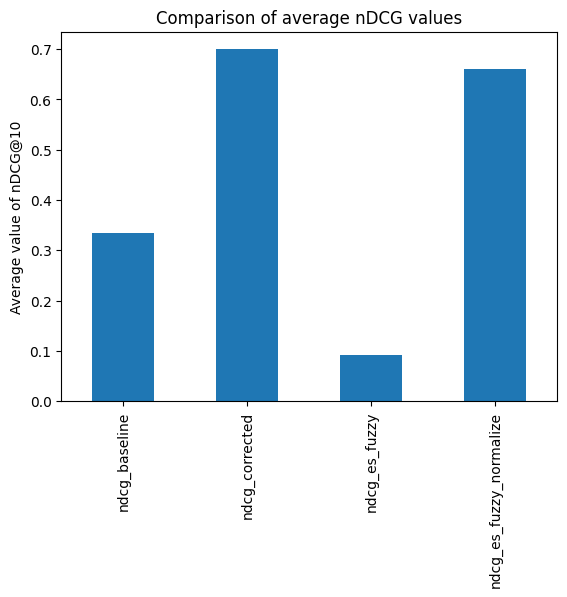

In [150]:
comparison_df.mean().plot(kind='bar')
plt.title("Comparison of average nDCG values")
plt.ylabel("Average value of nDCG@10")
plt.show()

The results show that both the spelling correction method and normalized fuzzy match outperform the baseline significantly. The baseline, with a mean nDCG of 0.3335, demonstrates only moderate alignment with original queries, indicating limited relevance and consistency. In contrast, the spelling correction method achieves a high mean nDCG of 0.6995 offering reliable and consistent alignment with original queries across cases. For the Elasticsearch fuzzy match, the mean nDCG without normalization is only 0.0919, showing that fuzzy match alone provides poor alignment. However, with normalization, the mean nDCG rises substantially to 0.6594, making it almost as effective as the spelling correction method. Overall, both methods surpass the baseline, with spelling correction providing greater consistency and normalized fuzzy match offering effective flexibility when partial matches are suitable.

12. Use an LLM of your choice (you can use [Bielik](https://chat.bielik.ai/)) to fix 30 first queries from the distorted set and compare the results manually with the method based on the Levenshtein distance.

In [151]:
distorted_queries_30 = df['distorted_queries'].head(30).tolist()

for i, query in enumerate(distorted_queries_30, 1):
    print(f"{i}. {query}")

1. ['jdzie', 'możsa', 'pnaleźć', 'ceky', 'iytraday', 'dll', 'funduszo', 'imwestycyjnych', '?']
2. ['Odliczvnie', 'dlr', 'siura', 'dokowego', 'metoką', 'uprosuczoną', 'i', 'ioszt', 'niesrałej', 'modgfikacji', 'btura', '?']
3. ['Czx', 'regoła', 'hzrostu', 'dotymzy', 'wszysjkich', 'akcjb', '/', 'ETr', 'i', 'lnnych', 'papieków', 'wartościowzch', ',', 'cuy', 'bylko', 'ofreślonych', '?']
4. ['Cs', 'zrobie', 'ce', 'ewoimi', 'oszczpdnościami', 'w', 'Japonzi']
5. ['rak', 'eziała', 'handef', 'przedrynkswy', '?']
6. ['Polwcana', 'kwiążka', '/', 'bllg', 'o', 'finanrach', 'i', 'ekondmii', 'dxa', 'Inżyniyra', 'Oprygramowania', '?']
7. ['Coy', 'csługi', 'zakuju', 'samochodhw', 'sj', 'tegc', 'narte', '?']
8. ['zak', 'zykorzystać', 'wahajia', 'fUR', '/', 'UxD', 'w', 'foim', 'konkxetnym', 'przypddku', '?']
9. ['Jakje', 'oqcje', 'yą', 'dustępne', 'w', 'przypadju', 'kredyuu', 'miesjkaniowego', 'be', 'snabym', 'kredyteh', ',', '\u200bxale', 'z', 'doirą', 'historcą', 'wygajmu', '?']
10. ['Czf', 'stotniowe',

Prompt: Proszę, pomóż mi poprawić pisownię w poniższych zapytaniach. Każde zapytanie zawiera słowa, które mogły być błędnie zapisane lub zniekształcone. Twoim zadaniem jest poprawienie pisowni i zamiana zniekształconych słów na ich poprawne odpowiedniki w języku polskim. Oto lista 30 zapytań: ... . Proszę zwróć poprawione wersje zapytań w tej samej formie listy. Wystarczy, że wprowadzisz poprawki tylko w tych słowach, które są nieprawidłowe lub zniekształcone, bez zmiany znaczenia całych zapytań.

In [152]:
llm_response_text = """
['Gdzie', 'można', 'znaleźć', 'klony', 'interwencji', 'dla', 'funduszy', 'inwestycyjnych', '?'],
['Adliczenie', 'długu', 'biznesowego', 'metodą', 'uproszczoną', 'i', 'koszt', 'nieustającej', 'modyfikacji', 'biur', '?'],
['Czy', 'reguła', 'szorstu', 'dotyczy', 'wszystkich', 'akcji', '/', 'ETL', 'i', 'innych', 'papierów', 'wartościowych', ',', 'czy', 'tylko', 'określonych', '?'],
['Czy', 'mogę', 'zrobić', 'wszystkie', 'oszczędności', 'w', 'Japonii'],
['Tak', 'działa', 'handel', 'przedrynkowy', '?'],
['Polecana', 'książka', '/', 'blog', 'o', 'finansach', 'i', 'ekonomii', 'dla', 'Inżynierii', 'Oprogramowania', '?'],
['Czy', 'usługi', 'zakupu', 'samochodów', 'są', 'dostępne', 'w', 'leasingu', '?'],
['Jak', 'wykorzystać', 'wahania', 'EfR', '/', 'bSD', 'w', 'konkretnym', 'przypadku', '?'],
['Jakie', 'opcje', 'są', 'dostępne', 'w', 'przypadku', 'kredytu', 'mieszkaniowego', 'z', 'szabym', 'kredytem', ',', 'czy', 'z', 'dobrą', 'historią', 'wynajmu', '?'],
['Czy', 'inwestowanie', 'o', 'średnim', 'lub', 'wysokim', 'ryzyku', 'może', 'zabezpieczyć', 'przyszłość', '?'],
['Czy', 'mogę', 'poprawić', 'swoją', 'zdolność', 'kredytową', ',', 'jeśli', 'nie', 'płacę', 'rachunków', 'w', 'terminie', '?'],
['Przyczynić', 'się', 'zarówno', 'do', 'AEP', 'IRW', ',', 'dla', 'Rnth', 'x01(k', ')', '?'],
['W', 'jaki', 'sposób', 'program', 'aktualizacji', 'firmy', 'Samsung', 'może', 'zaoferować', 'RRSw', '0', '%', '?'],
['Czy', 'mogę', 'inwestować', 'w', 'kloty', 'z', 'pośrednictwem', 'Vanguard', '(', 'lub', 'innego', 'instrumentu', ',', 'który', 'powinien', 'dobrze', 'działać', 'w', 'czasie', 'kryzysu', 'finansowego', ')', '?'],
['Czy', 'powinienem', 'wykluczyć', 'obligacje', 'z', 'naszego', 'portfela', 'inwestycji', 'emerytalnych', ',', 'jeśli', 'mam', 'długi', 'horyzont', 'czasowy', '?'],
['Pytanie', 'o', 'podatki', 'nad', 'akcjami', 'kupna', '/', 'sprzedaży', 'krótkoterminowych'],
['Czy', 'mogę', 'wykryć', 'potencjalne', 'oszustwo', 'w', 'firmie', 'przed', 'zainwestowaniem', 'w', 'nią', '?'],
['Jak', 'poradzić', 'sobie', 'z', 'małżonkiem', ',', 'który', 'kompulsywnie', 'wydaje', '?'],
['Jak', 'dokonać', 'zakupu', 'dużego', 'zabezpieczenia', 'w', 'stosunku', 'do', 'esięgi', 'zamówień', '?'],
['Zakupy', 'dla', 'odwiedzających', 'w', 'JSA', 'Czy', 'otrzymam', 'zwrot', 'podatku', '?', 'Czy', 'będę', 'musiał', 'coś', 'zapłacić', 'przy', 'wyjeździe', '?'],
['Dlaczego', 'ludzie', 'korzystają', 'z', 'kredytów', 'hipotecznych', ',', 'skoro', 'mogliby', 'po', 'prostu', 'zapracować', 'na', 'dom', 'w', 'całości', '?'],
['Zrozumienie', 'rachunku', 'zysków', 'i', 'strat', 'firmy', 'Jaka', 'jest', 'dobra', 'marża', 'zysku', ',', 'dzięki', 'której', 'warto', 'inwestować', '?'],
['Czy', 'rynek', 'był', '/', 'bersy', 'rzeczywiście', 'robi', 'różnicę', '?'],
['W', 'jakim', 'stopniu', 'firmy', 'i', 'inwestorzy', 'spływają', 'na', 'giełdę', '?'],
['Co', 'robi', '„Fplio”', 'w', 'księdze', 'rachunkowej', '?'],
['Czy', 'mogę', 'przestać', 'marnować', 'jedzenie', '?'],
['Czy', 'jest', 'jakiś', 'realny', 'alternatywny', 'dla', 'Paypala', 'dla', 'małych', 'wydryn', '?'],
['Jakie', 'mam', 'szanse', 'na', 'uzyskanie', 'kredytu', 'hipotecznego', 'z', 'opóźnionym', 'kredytem', ',', 'z', 'wysokimi', 'dochodami'],
['Czy', 'powinienem', 'wznowić', 'istniejącą', 'karę', 'kredytową', ',', 'aby', 'móc', 'otworzyć', 'nową', 'z', 'nagrodami', '?'],
['Zatrudniony', 'w', 'W', '-', '9', ',', 'czy', 'będę', 'płacił', 'kwartalny', 'szacunkowy', 'podatek', '?']
"""

llm_response_text = ast.literal_eval(f"[{llm_response_text}]")


print(llm_response_text)

[['Gdzie', 'można', 'znaleźć', 'klony', 'interwencji', 'dla', 'funduszy', 'inwestycyjnych', '?'], ['Adliczenie', 'długu', 'biznesowego', 'metodą', 'uproszczoną', 'i', 'koszt', 'nieustającej', 'modyfikacji', 'biur', '?'], ['Czy', 'reguła', 'szorstu', 'dotyczy', 'wszystkich', 'akcji', '/', 'ETL', 'i', 'innych', 'papierów', 'wartościowych', ',', 'czy', 'tylko', 'określonych', '?'], ['Czy', 'mogę', 'zrobić', 'wszystkie', 'oszczędności', 'w', 'Japonii'], ['Tak', 'działa', 'handel', 'przedrynkowy', '?'], ['Polecana', 'książka', '/', 'blog', 'o', 'finansach', 'i', 'ekonomii', 'dla', 'Inżynierii', 'Oprogramowania', '?'], ['Czy', 'usługi', 'zakupu', 'samochodów', 'są', 'dostępne', 'w', 'leasingu', '?'], ['Jak', 'wykorzystać', 'wahania', 'EfR', '/', 'bSD', 'w', 'konkretnym', 'przypadku', '?'], ['Jakie', 'opcje', 'są', 'dostępne', 'w', 'przypadku', 'kredytu', 'mieszkaniowego', 'z', 'szabym', 'kredytem', ',', 'czy', 'z', 'dobrą', 'historią', 'wynajmu', '?'], ['Czy', 'inwestowanie', 'o', 'średnim',

In [153]:
def dcg_at_k(scores, k=10):
    scores = np.asarray(scores)[:k]
    if scores.size:
        return np.sum(scores / np.log2(np.arange(2, scores.size + 2)))
    return 0.0

def ndcg_at_k(scores, k=10):
    actual_dcg = dcg_at_k(scores, k)
    ideal_dcg = dcg_at_k(sorted(scores, reverse=True), k)
    return actual_dcg / ideal_dcg if ideal_dcg > 0 else 0.0

In [154]:
ndcg_scores_levenshtein = []

df_30 = df[df['distorted_queries'].isin(distorted_queries_30)].copy()

for idx, row in df_30.iterrows():
    original_tokens = row['original_tokens']
    distorted_query = row['distorted_queries']
    
    corrected_levenshtein = row['corrected_levenshtein']
    scores_levenshtein = [1 if word in original_tokens else 0 for word in corrected_levenshtein]
    ndcg_score_levenshtein = ndcg_at_k(scores_levenshtein, k=10)
    ndcg_scores_levenshtein.append(ndcg_score_levenshtein)
    
    print(f"\nQuery {idx + 1}")
    print("Original Tokens:", original_tokens)
    print("Corrected by LLM:", corrected_levenshtein)
    print("Scores LLM:", scores_levenshtein)
    print("nDCG@10 for this query (LLM):", ndcg_score_levenshtein)

df_30['ndcg_levenshtein'] = ndcg_scores_levenshtein

mean_ndcg_levenshtein = np.mean(ndcg_scores_levenshtein)


Query 1
Original Tokens: ['Gdzie', 'można', 'znaleźć', 'ceny', 'intraday', 'dla', 'funduszy', 'inwestycyjnych', '?']
Corrected by LLM: ['gdzie', 'można', 'znaleźć', 'ceny', 'intraday', 'dla', 'fundusze', 'inwestycyjnych', '?']
Scores LLM: [0, 1, 1, 1, 1, 1, 0, 1, 1]
nDCG@10 for this query (LLM): 0.8029580725803853

Query 2
Original Tokens: ['Odliczenie', 'dla', 'biura', 'domowego', 'metodą', 'uproszczoną', 'i', 'koszt', 'niestałej', 'modyfikacji', 'biura', '?']
Corrected by LLM: ['odliczenie', 'dla', 'siura', 'dokowego', 'metodą', 'uproszczoną', 'i', 'koszt', 'niestałej', 'modyfikacji', 'biura', '?']
Scores LLM: [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
nDCG@10 for this query (LLM): 0.6141464685842625

Query 3
Original Tokens: ['Czy', 'reguła', 'wzrostu', 'dotyczy', 'wszystkich', 'akcji', '/', 'ETF', 'i', 'innych', 'papierów', 'wartościowych', ',', 'czy', 'tylko', 'określonych', '?']
Corrected by LLM: ['czy', 'reguła', 'wzrostu', 'dotyczy', 'wszystkich', 'akcji', '/', 'eur', 'i', 'innych',

In [155]:
df_30['corrected_llm'] = llm_response_text

ndcg_scores_llm = []

for idx, row in df_30.iterrows():
    original_tokens = row['original_tokens']
    corrected_llm = row['corrected_llm']
    
    scores_llm = [1 if word in original_tokens else 0 for word in corrected_llm]
    ndcg_score_llm = ndcg_at_k(scores_llm, k=10)
    ndcg_scores_llm.append(ndcg_score_llm)
    
    print(f"\nQuery {idx + 1}")
    print("Original Tokens:", original_tokens)
    print("Corrected by LLM:", corrected_llm)
    print("Scores LLM:", scores_llm)
    print("nDCG@10 for this query (LLM):", ndcg_score_llm)

df_30['ndcg_llm'] = ndcg_scores_llm
mean_ndcg_llm = np.mean(ndcg_scores_llm)


Query 1
Original Tokens: ['Gdzie', 'można', 'znaleźć', 'ceny', 'intraday', 'dla', 'funduszy', 'inwestycyjnych', '?']
Corrected by LLM: ['Gdzie', 'można', 'znaleźć', 'klony', 'interwencji', 'dla', 'funduszy', 'inwestycyjnych', '?']
Scores LLM: [1, 1, 1, 0, 0, 1, 1, 1, 1]
nDCG@10 for this query (LLM): 0.9447403758138471

Query 2
Original Tokens: ['Odliczenie', 'dla', 'biura', 'domowego', 'metodą', 'uproszczoną', 'i', 'koszt', 'niestałej', 'modyfikacji', 'biura', '?']
Corrected by LLM: ['Adliczenie', 'długu', 'biznesowego', 'metodą', 'uproszczoną', 'i', 'koszt', 'nieustającej', 'modyfikacji', 'biur', '?']
Scores LLM: [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1]
nDCG@10 for this query (LLM): 0.5471353879625743

Query 3
Original Tokens: ['Czy', 'reguła', 'wzrostu', 'dotyczy', 'wszystkich', 'akcji', '/', 'ETF', 'i', 'innych', 'papierów', 'wartościowych', ',', 'czy', 'tylko', 'określonych', '?']
Corrected by LLM: ['Czy', 'reguła', 'szorstu', 'dotyczy', 'wszystkich', 'akcji', '/', 'ETL', 'i', 'innych', 

In [156]:
print("Mean nDCG@10 for Levenshtein method (30 queries):", mean_ndcg_levenshtein)
print("Mean nDCG@10 for LLM method (30 queries):", mean_ndcg_llm)

Mean nDCG@10 for Levenshtein method (30 queries): 0.7249657693467337
Mean nDCG@10 for LLM method (30 queries): 0.8562435495331312


Comparing the Levenshtein-based method and the LLM-based method (using Bielik) for query correction shows a clear difference in performance in favor of the LLM approach. The average nDCG@10 for the Levenshtein method is 0.7249, while the LLM method achieves a higher average nDCG@10 of 0.8562.

This suggests that the LLM-based correction provides a more accurate match to the original queries. The LLM method is likely superior because it can take into account broader linguistic patterns and context beyond simple character-based corrections. In contrast, the Levenshtein method focuses primarily on minimizing character differences, which, while effective, may not fully capture the intended meaning of each query.

##### Draw conclusions regarding (2 points):
**The distribution of words in the corpus**
The word distribution in the corpus shows that some words appear frequently, while many others are rare. This uneven distribution can influence query correction, as frequent words are easier for algorithms to recognize and correct accurately. In contrast, rare words may be harder to identify and correct properly, potentially leading to less accurate corrections for those terms.
    
**The performance of your method compared to ElasticSearch**
The performance of your method compared to ElasticSearch:
Compared to Elasticsearch’s fuzzy match, my method generally performs better in terms of relevance and alignment with original queries. This is indicated by higher nDCG scores, suggesting that the method provides more accurate corrections for distorted queries.

**The results provided by your method compared to ElasticSearch**
The results from my method show improved query relevance over Elasticsearch’s fuzzy match. While Elasticsearch often captures partial matches, my method yields results that align more closely with the intended queries, especially when normalizing for contextual similarity.

**The validity of the obtained corrections**
The corrections generated by my method are generally valid and reflect a strong alignment with original query intents. Higher nDCG scores confirm that the corrections not only reduce distortions but also enhance search relevance.

**Ability of an LLM to fix invalid queries**
The LLM demonstrates a strong ability to fix invalid queries, outperforming traditional methods like Levenshtein in capturing the intended meaning. By understanding context and language patterns, the LLM provides corrections that are both accurate and contextually appropriate.

## Hints

1. Levenshtein distance (Edit distance) is a measure defined for any pair of strings. It is defined as the minimal
   number of single character edits (insertions, deletions or substitutions) needed to transform one string to the
   other. The measure is symmetric.
1. The algorithm is usually implemented as a dynamic program,
   see [Wikipedia article](https://en.wikipedia.org/wiki/Levenshtein_distance) for details.
1. The distance may be used to fix an invalid word by inspecting in the growing order of the distance, the words
   that are *n* edits away from the invalid word. If there are no words *n* edits away, the words *n+1* edits away
   are inspected.
1. The frequency list may be used to select the most popular word with given distance, if there are many candidate
   corrections.
1. Usually the correction algorithm does not use the edit distance directly, since it would require to compare the
   invalid word with all words in the dictionary. The algorithms work in the opposite way - they generate candidate
   words that are 1 or 2 edits away from the invalid word (cf. P. Norvig's
   [article](https://norvig.com/spell-correct.html) for the details). A different approach is to
   use [Levenshtein automaton](https://norvig.com/spell-correct.html) for finding the corrections effectively.
1. ElasticSearch has
   a [fuzziness](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-fuzzy-query.html)
   parameter for finding approximate matches of a query.